# Стохастический градиентный спуск

Сохраните ваше решение в формате Name_Surname.ipynb, например Ivan_Ivanov.ipynb

Credits: [Евгений Соколов](https://github.com/esokolov)

### О задании

Задание состоит из двух частей: в **первой** части вы научитесь применять готовые модели из `sklearn` на данных и исследуете особенности разных видов регуляризации; во **второй** части вы реализуете собственный класс линейной регрессии для нестандартной функции потерь (включая процесс обучения) и исследуете скорость сходимости различных градиентных методов для этой модели.

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from seaborn import pairplot, jointplot
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('SGD data.txt')

## Линейная регрессия из коробки

#### 1.  Разбейте выборку, загруженную в ячейке выше в переменную `df`, на обучающую и тестовую части в соотношении 8:2.

In [5]:
# your code here
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['f1']), df['f1'], test_size = 2/8)

#### 2. В качестве целевой переменной для задачи регрессии будем использовать значения признака f1. Обучите, а затем провалидируйте на тестовых данных  следующие модели, используя в качестве метрики качества $R^2$:
* [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html);
* [`Lasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) (линейная регрессия с $L1$-регуляризатором) с коэффициентом регуляризации, равным 0.01.

Не забудьте отмасштабировать данные перед обучением моделей!

In [10]:
scaler = StandardScaler().fit(X_train)

In [13]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
LR = LinearRegression()
lasso = Lasso(alpha=0.01)

In [15]:
LR.fit(X_train, y_train)
lasso.fit(X_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [18]:
print(f'Linear Regression: {LR.coef_}')
print(f'Lasso: {lasso.coef_}')

Linear Regression: [ 0.94048     0.04167034  0.02105292  0.01892134  0.13118331 -0.00415848]
Lasso: [ 0.93061075  0.03124047  0.00956561  0.00767574  0.12260077 -0.        ]


#### 3. Изучите значения параметров получившихся моделей и сравните количество строго нулевых весов в них.

In [24]:
print(f'num of nulls in Linear Regression: {sum(LR.coef_==0)}')
print(f'num of nulls in Lasso: {sum(lasso.coef_==0)}')
print(f'parameters difference: {LR.coef_ - lasso.coef_}')

num of nulls in Linear Regression: 0
num of nulls in Lasso: 1
parameters difference: [ 0.00986925  0.01042987  0.01148731  0.0112456   0.00858255 -0.00415848]


In [223]:
r2_score(y_test, lasso.predict(X_test))

0.43465984995579754

#### 4. Нарисуйте попарные scatter plot для всех признаков в исходных данных (включая f1). Можно ли что-то сказать о связи признаков, веса которых были занулены методом Lasso, с целевой переменной?

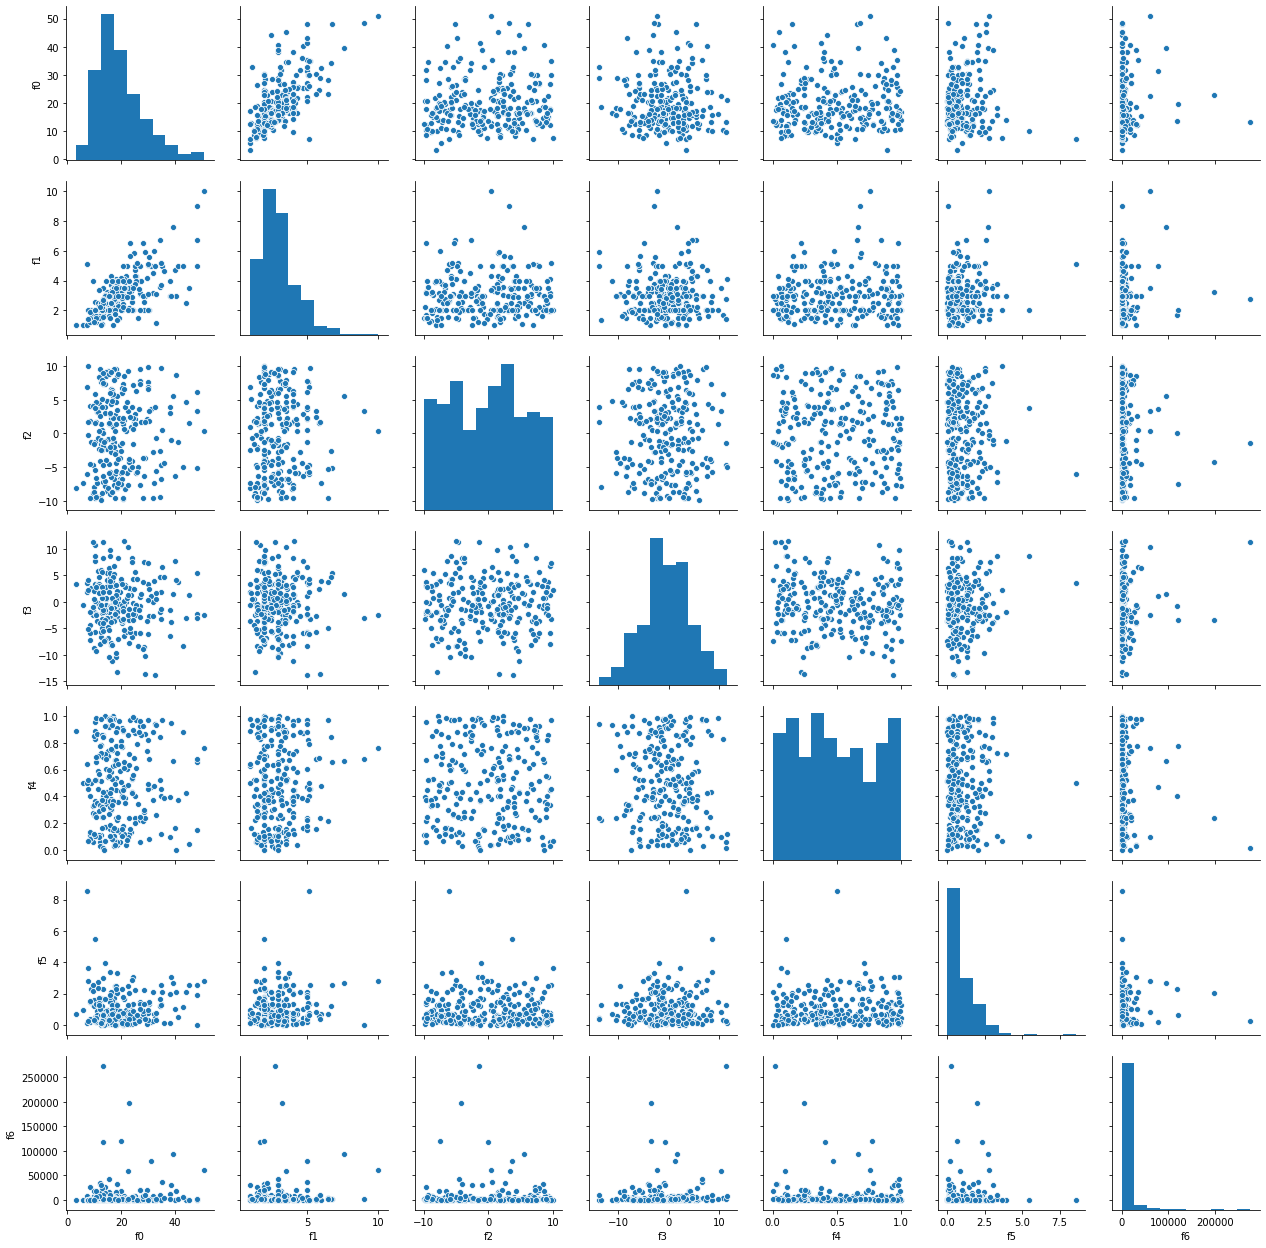

In [26]:
pairplot(df)

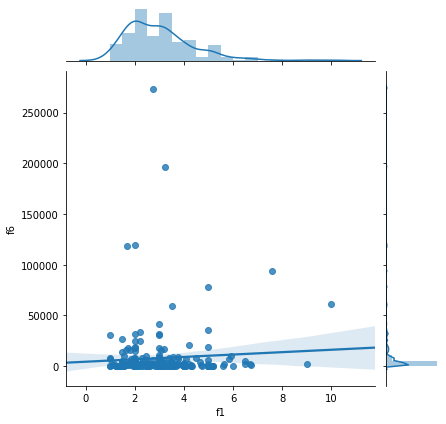

In [28]:
jointplot("f1", "f6", data=df, kind="reg")

Признак f6 имеет собран в одном промежутке практически для всех f1 -- признак не является информативным

## Реализация градиентного спуска

#### 5. Реализуйте модель линейной регрессии для функции потерь Huber loss, обучаемую градиентным спуском:

$$
L_\delta(a,y)=
\begin{cases}
 \frac{1}{2}(\hat{y} - y)^2,                   & |\hat{y} - y| \le \delta, \\
 \delta\, |\hat{y} - y| - \frac{1}{2}\delta^2 & \textrm{иначе.}
\end{cases}
$$

Все вычисления должны быть векторизованы, циклы средствами python допускается использовать только для итераций градиентного спуска. В качестве критерия останова необходимо использовать (одновременно):

* проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, задаваемого параметром `tolerance`);
* достижение максимального числа итераций (например, 10000, задаваемого параметром `max_iter`).

Необходимо реализовать метод полного и стохастического градиентных спусков, а также поддержать метод инерции (SGD with momentum - см.лекцию) при помощи параметра `alpha` (способ оценивания градиента должен задаваться при помощи параметра `gd_type`).

Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса `loss_history` — в нём после вызова метода `fit` должны содержаться значения функции потерь для всех предшествующих итераций.

Инициализировать веса можно случайным образом или нулевым вектором. Ниже приведён шаблон класса, который должен содержать код реализации модели.

In [563]:
from sklearn.base import BaseEstimator
from sklearn.metrics import r2_score
import numpy as np

class HuberReg(BaseEstimator):
    def __init__(self, delta=1.0, gd_type='stochastic', 
                 tolerance=1e-5, max_iter=1000, w0=None, alpha=0.9, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (D) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        self.delta = delta
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.velocity = 0
        self.w = None
        self.eta = eta
        self.loss_history = [] # list of loss function values at each training iteration
    
    def fit(self, X, y):
        """
        X: np.array of shape (K, D)
        y: np.array of shape (K)
        ---
        output: self
        """
        y = np.array(y).reshape(-1,1)
        X = np.array(X)
        indexes = np.arange(X.shape[0])
        in_size = np.array(X).shape[1] + 1
        out_size = 1
        self.w = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2 / (in_size + out_size))
        for _ in range(self.max_iter):
            if self.gd_type == 'stochastic':
                iter_loss = []
                for j in range(X.shape[0]):
                    ind = np.random.choice(indexes)
                    x = X[ind].reshape(1,-1)
                    y_x = y[ind]
                    loss = self.calc_loss(x, y_x)
                    iter_loss.append(loss)
                    grad = self.calc_gradient(x, y_x)
                    w_old = self.w
                    velocity_old = self.velocity
                    self.velocity = velocity_old*self.alpha + (1-self.alpha)*grad
                    self.w = self.w - self.velocity * self.eta
                self.loss_history.append(np.mean(iter_loss))
            else:
                x = X
                y_x = y
                loss = self.calc_loss(x, y_x)
                self.loss_history.append(loss)
                grad = self.calc_gradient(x, y_x)
                w_old = self.w
                velocity_old = self.velocity
                self.velocity = velocity_old*self.alpha + (1-self.alpha)*grad
                self.w = self.w - self.velocity * self.eta
            if np.linalg.norm(self.w-w_old) < self.tolerance:
                break

        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        X = self.add_ones(X)
        return np.dot(X, self.w.T)
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (K, D) (K can be equal to 1 if stochastic)
        y: np.array of shape (K)
        ---
        output: np.array of shape (D)
        """
        N = np.array(X).shape[0]
        
        y_pred = self.predict(X)
        X = self.add_ones(X)
        abs_diff = np.sum(np.abs(y - y_pred))/N
        
        if abs_diff < self.delta:
            return np.sum((y_pred-y)*X, axis=0)/N
        else:
            if_bigger = (y_pred > y).reshape(-1)
            bigger = np.sum(self.delta*X[if_bigger,:], axis=0)
            lower = -np.sum(self.delta*X[~if_bigger,:], axis=0)
            return (bigger+lower)/N

    def calc_loss(self, X, y):
        """
        X: np.array of shape (K, D)
        y: np.array of shape (K)
        ---
        output: float 
        """ 
        N = np.array(X).shape[0]
        
        y_pred = self.predict(X)
        X = self.add_ones(X)
        abs_diff = np.sum(np.abs(y - y_pred))/N
        if abs_diff < self.delta:
            return (0.5*np.sum((y_pred-y)**2))/N
        else:
            return (self.delta*abs_diff - (self.delta**2)/(2*N))
        
    def add_ones(self, X):
        X = np.array(X)
        ones = np.ones((X.shape[0],1))
        return np.concatenate((X,ones), axis=1)
    
    def score(self, X, y_test):
        y_pred = self.predict(X)
        return r2_score(y_test, y_pred)

#### 6. Обучите и провалидируйте модель на тех же данных, сравните качество с предыдущими методами. Исследуйте влияние параметров `max_iter` и `alpha` на процесс оптимизации. Согласуется ли оно с вашими ожиданиями?

In [564]:
model = HuberReg(gd_type='full')
GS = GridSearchCV(model, param_grid={'max_iter': [100, 1000, 2000], 'alpha': [0, 0.5, 0.9], 'delta': [0.01, 1, 2]})
GS.fit(X_train, y_train)

/home/analekseev/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=HuberReg(alpha=0.9, delta=1.0, eta=0.01, gd_type='full',
                                max_iter=1000, tolerance=1e-05, w0=None),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0, 0.5, 0.9], 'delta': [0.01, 1, 2],
                         'max_iter': [100, 1000, 2000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [565]:
results = pd.DataFrame(GS.cv_results_['params'])
results['score'] = GS.cv_results_['mean_test_score']
results

,alpha,delta,max_iter,score
0,0.0,0.01,100,-5.417054
1,0.0,0.01,1000,-3.780991
2,0.0,0.01,2000,-3.908803
3,0.0,1.00,100,-3.461045
4,0.0,1.00,1000,0.389292
5,0.0,1.00,2000,0.388655
6,0.0,2.00,100,-2.019864
7,0.0,2.00,1000,0.389120
8,0.0,2.00,2000,0.388977
9,0.5,0.01,100,-6.324483


In [566]:
print(f'Best model r2 score on test {r2_score(y_test, GS.predict(X_test))}')

Best model r2 score on test 0.43412783976909064


При малых delta модель не учится, тк градиент получается очень малым, также итераций должно быть не менее 100, alpha играет небольшую роль при нестохастическом градиентном спуске.

In [568]:
model = HuberReg()
GS = GridSearchCV(model, param_grid={'max_iter': [100, 1000], 'alpha': [0, 0.5, 0.99], 'delta': [0.01, 1, 2]})
GS.fit(X_train, y_train)

/home/analekseev/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=HuberReg(alpha=0.9, delta=1.0, eta=0.01,
                                gd_type='stochastic', max_iter=1000,
                                tolerance=1e-05, w0=None),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0, 0.5, 0.99], 'delta': [0.01, 1, 2],
                         'max_iter': [100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [569]:
results = pd.DataFrame(GS.cv_results_['params'])
results['score'] = GS.cv_results_['mean_test_score']
results

,alpha,delta,max_iter,score
0,0.00,0.01,100,-2.272626
1,0.00,0.01,1000,-0.186033
2,0.00,1.00,100,0.341864
3,0.00,1.00,1000,0.362839
4,0.00,2.00,100,0.366025
5,0.00,2.00,1000,0.344235
6,0.50,0.01,100,-2.577753
7,0.50,0.01,1000,0.353795
8,0.50,1.00,100,0.380639
9,0.50,1.00,1000,0.387939


In [577]:
print(f'Best model r2 score on test {r2_score(y_test, GS.predict(X_test))}')

Best model r2 score on test 0.4328453712683422


Аналогично предыдущему случаю, только alpha играет значительную роль тк на каждой итерации градиент "не стабилен".

#### 7. Постройте графики (на одной и той же картинке) зависимости величины функции потерь от номера итерации для полного, стохастического градиентного спусков, а также для полного градиентного спуска с методом инерции (SGD with momentum - см.лекцию). Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.

Не забывайте о том, что должны из себя представлять *красивые* графики!

In [571]:
# your code here
model = HuberReg(alpha=0)
model.fit(X_train, y_train)
loss_stoh_SGD = model.loss_history
model = HuberReg(gd_type='full', alpha=0)
model.fit(X_train, y_train)
loss_full_SGD = model.loss_history

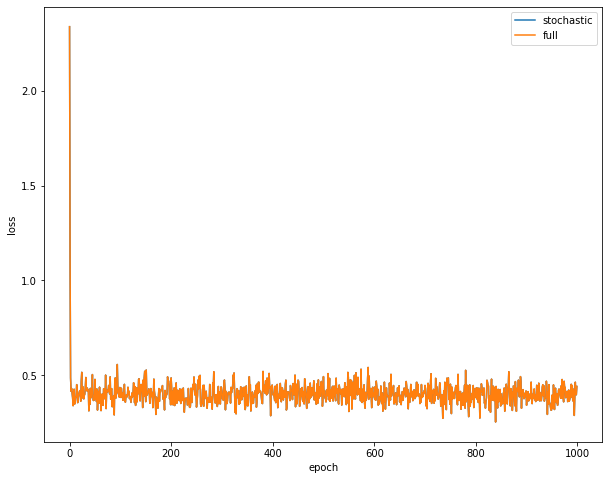

In [580]:
plt.figure(figsize=(10,8))
plt.plot(loss_stoh_SGD, label='stochastic')
plt.plot(loss_stoh_SGD, label='full')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [573]:
model = HuberReg(alpha=0.9)
model.fit(X_train, y_train)
loss_stoh_SGDM = model.loss_history
model = HuberReg(gd_type='full', alpha=0.9)
model.fit(X_train, y_train)
loss_full_SGDM = model.loss_history

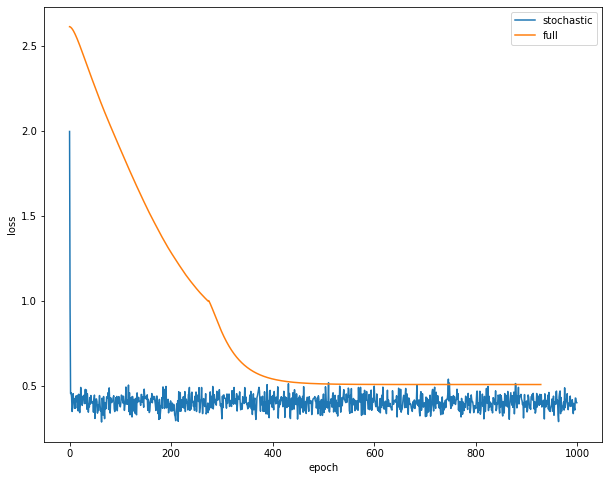

In [579]:
plt.figure(figsize=(10,8))
plt.plot(loss_stoh_SGDM, label='stochastic')
plt.plot(loss_full_SGDM, label='full')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

При 'full' нет необходимости использовать SGD + Momentum, тогда как при стохастическом градиентном спуске, этот способ обновления весов, может помоч градиенту сходится быстрее и не реагировать на шум в данных